# Test sampling algorithms

In [1]:
import os
import time

import numpy as np
import psdist as ps
import psdist.plot as psv
import scipy.interpolate
import ultraplot as plt
from tqdm import tqdm

import ment

In [2]:
plt.rc["cmap.discrete"] = False
plt.rc["cmap.sequential"] = "viridis"
plt.rc["figure.facecolor"] = "white"
plt.rc["grid"] = False

Create a particle distribution.

In [3]:
# Settings
ndim = 4
size = 1_000_000
n_modes = 5
seed = 1241

# Create gaussian particle distribution
rng = np.random.default_rng(seed)
mean = np.zeros(ndim)
cov = np.identity(ndim)
for i in range(ndim):
    for j in range(i):
        cov[i, j] = cov[j, i] = rng.uniform(-0.4, 0.4)
x = rng.multivariate_normal(mean, cov, size=size)

# Add gaussian blobs
for _ in range(n_modes):
    scale = rng.uniform(0.8, 1.5, size=ndim)
    loc = rng.uniform(-5.0, 3.0, size=ndim)
    x = np.vstack([x, rng.normal(loc=loc, scale=scale, size=(size // n_modes, ndim))])
x = x - np.mean(x, axis=0)

rng.shuffle(x)

x_true = np.copy(x)

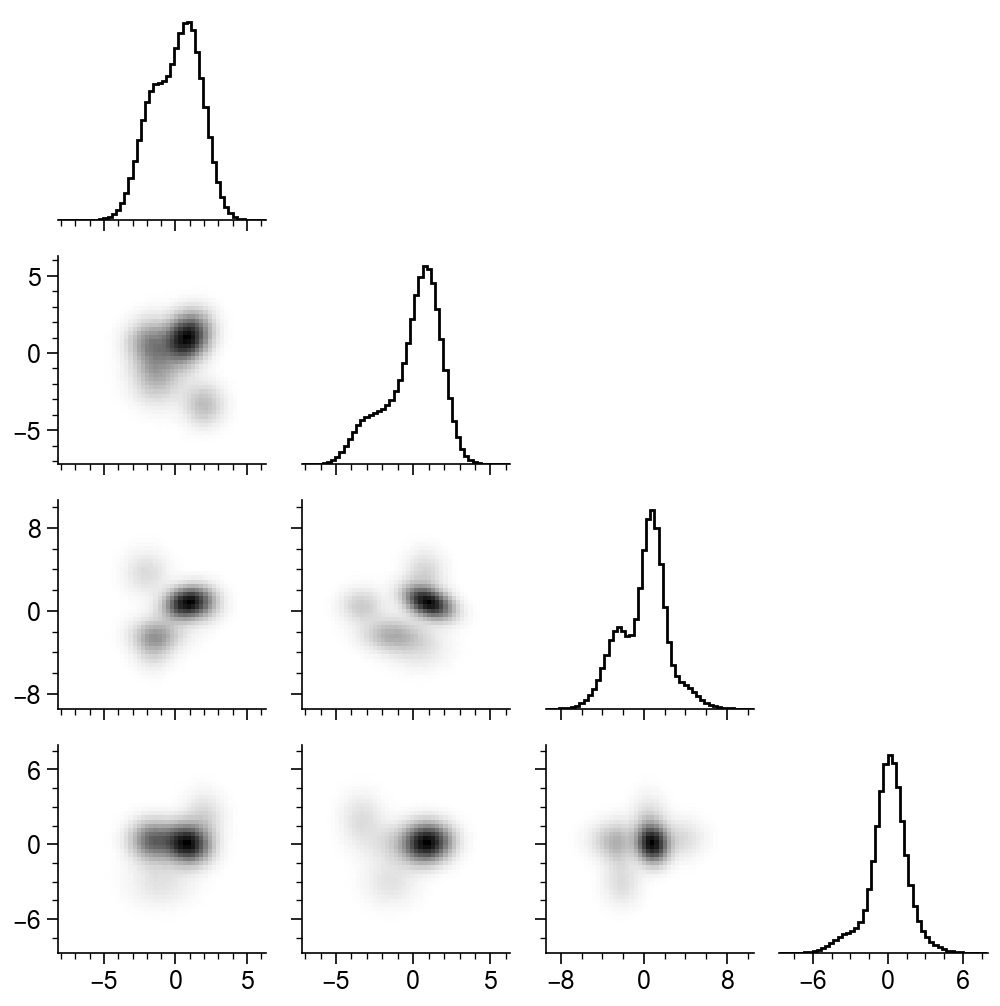

In [4]:
limits = ps.limits(x_true)

grid = psv.CornerGrid(ndim, corner=True, figwidth=(1.25 * ndim))
grid.plot(x_true, bins=50, limits=limits, cmap="mono")
plt.show()

Compute ground-truth histogram. This will act as our ground-truth distribution function to sample from.

In [5]:
n_bins = 25
values, edges = np.histogramdd(x_true, bins=n_bins, range=limits, density=True)
hist = ps.Histogram(values=values, edges=edges)
print("hist.shape =", hist.shape)

hist.shape = (25, 25, 25, 25)


Interpolate to obtain a smooth density function.

In [6]:
prob_func = scipy.interpolate.RegularGridInterpolator(
    hist.coords,
    hist.values,
    method="linear",
    bounds_error=False,
    fill_value=0.0,
)

## Grid Sampling (GS)

In [7]:
samp_grid_res = 15  # limit ~ 15
grid_shape = [samp_grid_res] * ndim
grid_limits = limits

sampler = ment.samp.GridSampler(
    grid_limits=grid_limits,
    grid_shape=grid_shape,
    noise=0.0,
)

start_time = time.time()
x_samp = sampler(prob_func, size)

print("time:", time.time() - start_time)

time: 0.14651727676391602


Plot a samples over histogram projections.

In [8]:
def plot_corner_samp(x_samp: np.ndarray):
    limits = ps.limits(x_true, rms=2.5)

    grid = psv.CornerGrid(ndim, corner=True, figwidth=(1.25 * ndim))
    grid.set_limits(limits)
    grid.plot_hist(hist, cmap="mono")
    grid.plot(x_samp[:, :], kind="hist", alpha=0.0, diag_kws=dict(color="red"))
    grid.plot(
        x_samp[:1000, :],
        diag=False,
        kind="scatter",
        color="red",
        s=0.25,
    )
    return grid

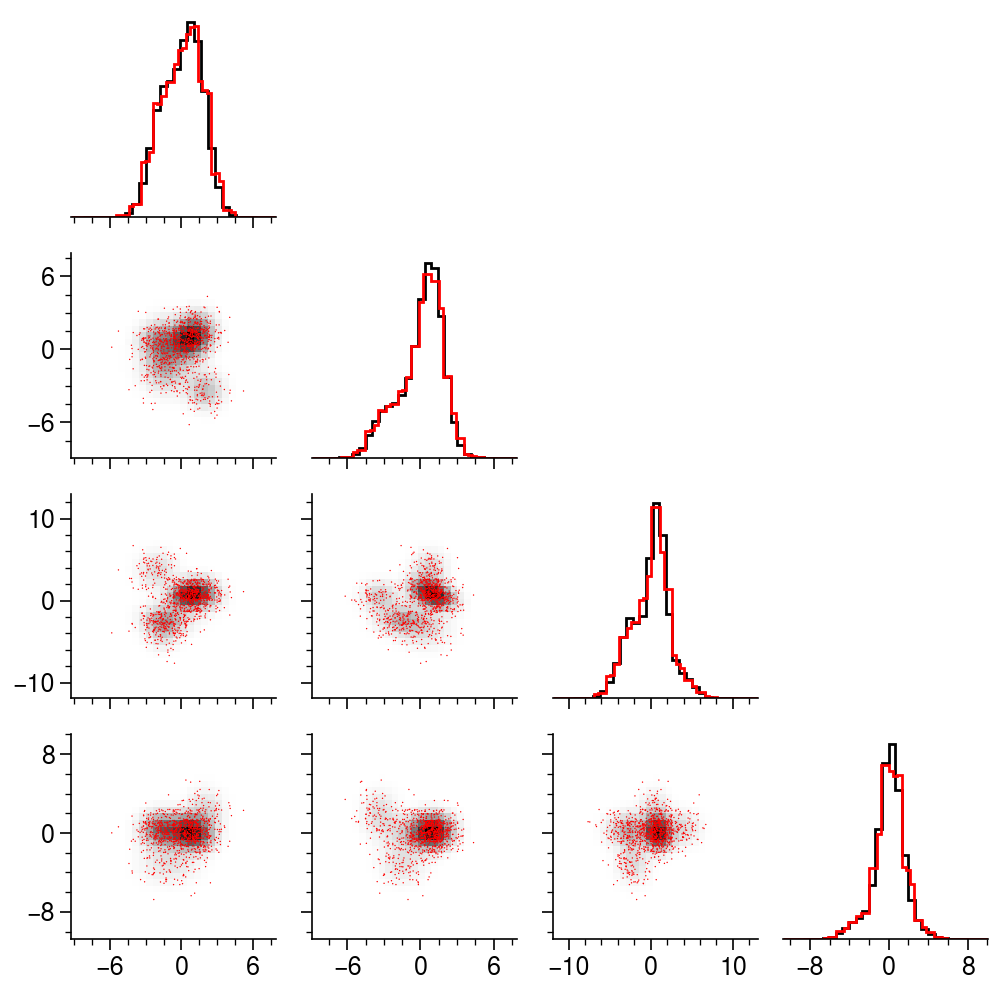

In [9]:
grid = plot_corner_samp(x_samp)

## Slice Grid Sampling (GS)

In [10]:
samp_res = 20
int_res = 10

ndim_proj = 2
ndim_samp = ndim_int = ndim - ndim_proj

grid_shape = [samp_res] * ndim
grid_limits = limits
int_size = int(int_res**ndim_int)

sampler = ment.samp.SliceGridSampler(
    grid_limits=grid_limits,
    grid_shape=grid_shape,
    proj_dim=ndim_proj,
    int_size=int_size,
    int_method="grid",
    int_batches=1,
    noise=0.0,
    verbose=True,
)

start_time = time.time()
x_samp = sampler(prob_func, size)
print("time:", time.time() - start_time)

Projecting


  0%|                                                                                                                                                                  | 0/400 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:00<00:00, 10266.44it/s]

Sampling


0it [00:00, ?it/s]

292it [00:00, 2901.00it/s]

400it [00:00, 3319.32it/s]

time:

 0.7967720031738281


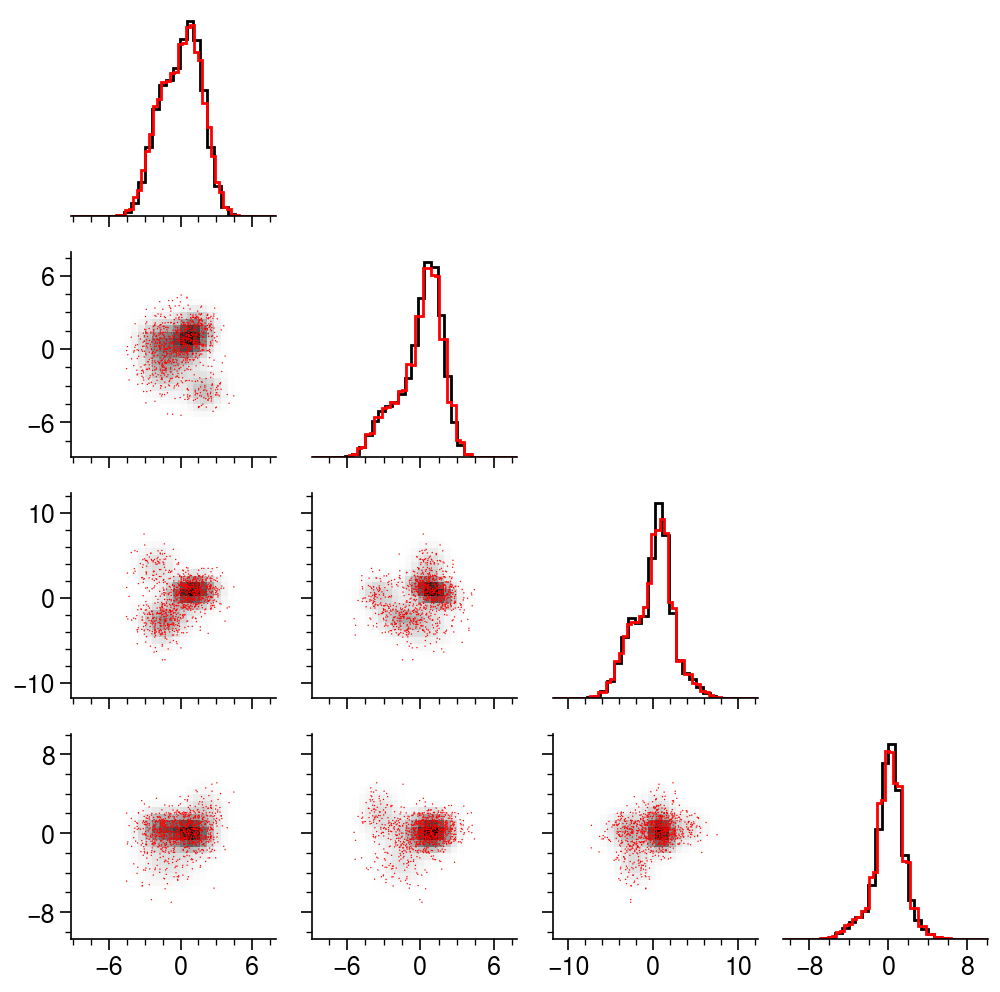

In [11]:
grid = plot_corner_samp(x_samp)

## Metropolis-Hastings

In [12]:
sampler = ment.samp.MetropolisHastingsSampler(
    ndim=ndim,
    proposal_cov=np.eye(ndim),
    start=None,
    chains=1,
    burnin=1_000,
    shuffle=True,
)
x_samp = sampler(prob_func, size=100_000)

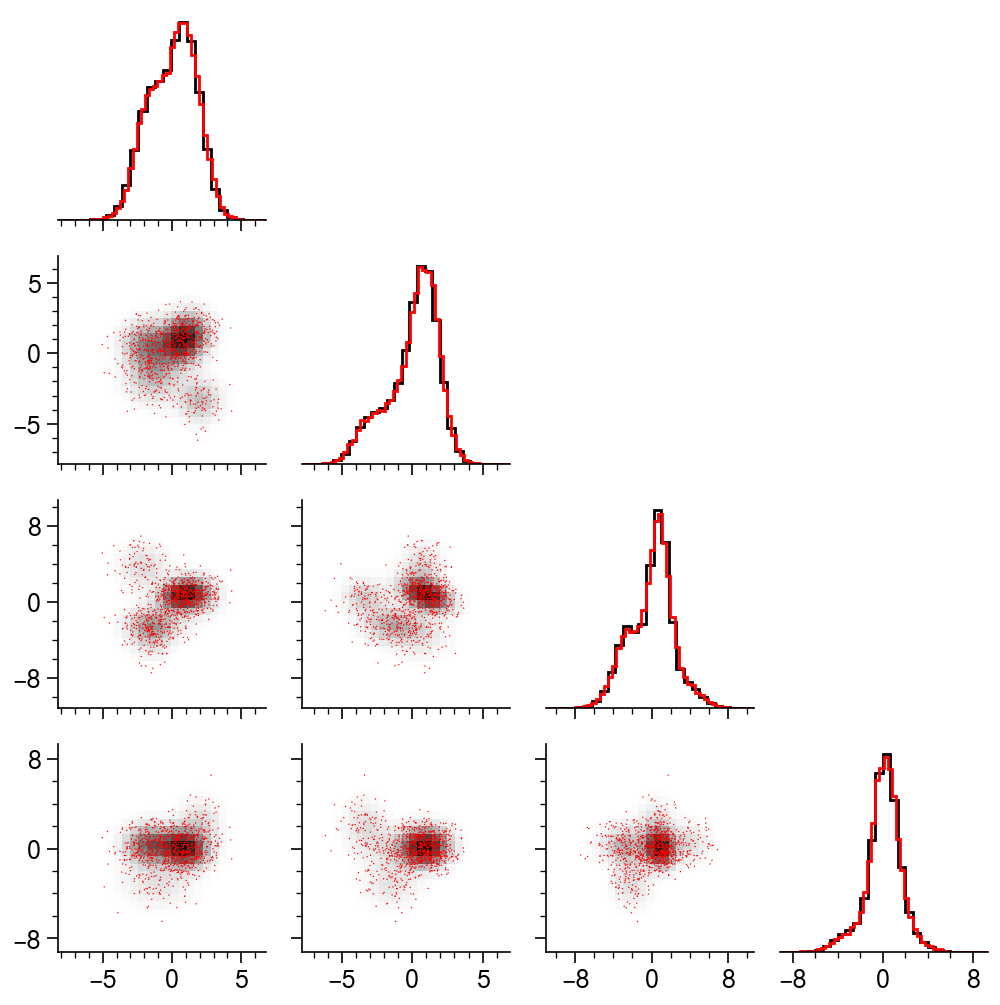

In [13]:
grid = plot_corner_samp(x_samp)

In [14]:
sampler = ment.samp.MetropolisHastingsSampler(
    ndim=ndim,
    proposal_cov=np.eye(ndim),
    start=None,
    chains=10,
    burnin=1_000,
    shuffle=True,
    verbose=True,
)
x_samp = sampler(prob_func, size=100_000)

  0%|                                                                                                                                                                | 0/10999 [00:00<?, ?it/s]

 11%|████████████████▌                                                                                                                                 | 1249/10999 [00:00<00:00, 12481.89it/s]

 23%|█████████████████████████████████▏                                                                                                                | 2498/10999 [00:00<00:00, 10556.31it/s]

 32%|███████████████████████████████████████████████▍                                                                                                  | 3573/10999 [00:00<00:00, 10282.98it/s]

 42%|█████████████████████████████████████████████████████████████▏                                                                                    | 4611/10999 [00:00<00:00, 10019.10it/s]

 51%|███████████████████████████████████████████████████████████████████████████                                                                        | 5618/10999 [00:00<00:00, 9871.77it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 6724/10999 [00:00<00:00, 10249.26it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 7959/10999 [00:00<00:00, 10908.82it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 9056/10999 [00:00<00:00, 10721.80it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 10133/10999 [00:00<00:00, 10345.39it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10999/10999 [00:01<00:00, 10400.13it/s]

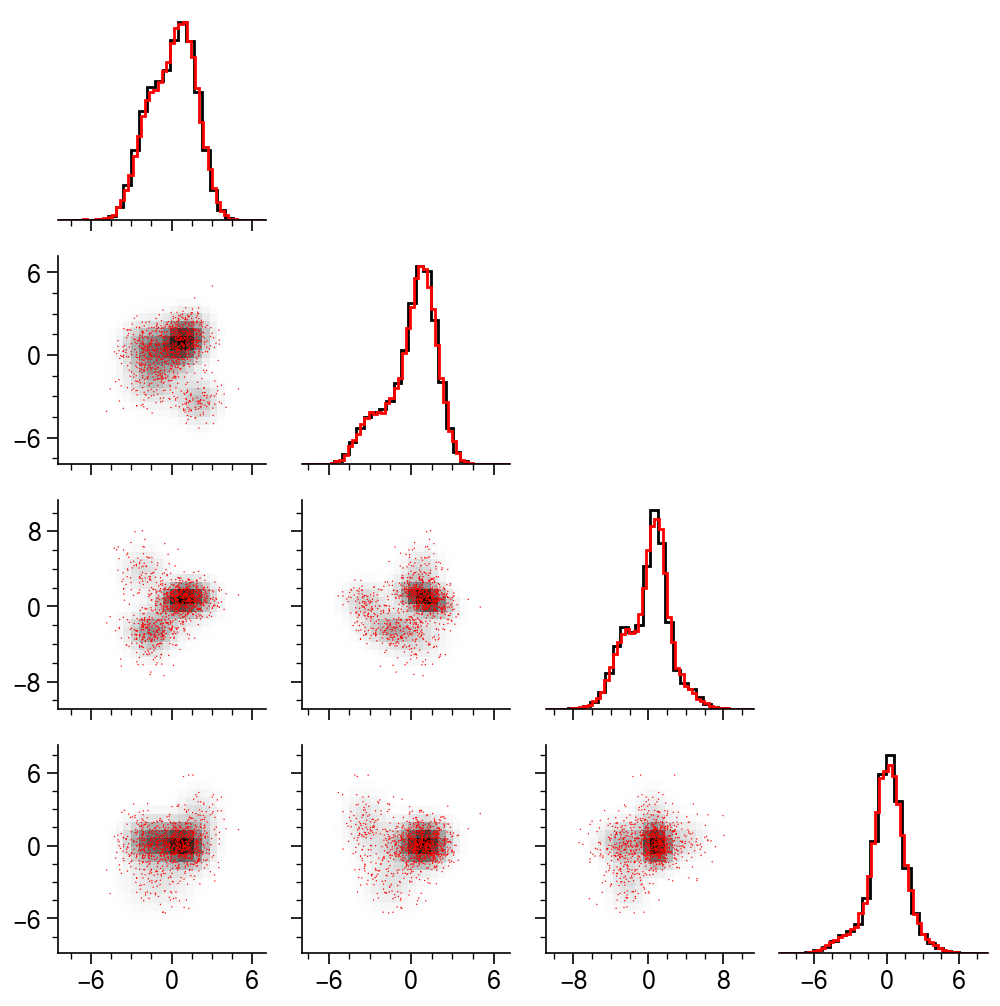

In [15]:
grid = plot_corner_samp(x_samp)